# 采用最优控制数值解求解无障碍物泊车问题

## 车辆参数

- 轴距： `lw = 2.8`
- 前轮突出 1 米：`lf = 1.0`
- 后轮突出 1 米：`lr = 1.0`
- 车宽：`lb = 1.85`
- 最大速度: `vmax = 3.0`
- 最小速度：`vmin = -2.0`
- 最大加速度：`amax = 2.0`
- 最小加速度：`amin = -1.0`
- 前轮最大转角：`phi_max = 0.63792`  (36.55°)
- 方向盘最大转速：`omega_max = 0.63792` 

## 场景参数

<div align="center">
<img src="1.jpg" width=700>
</div>

## 状态方程离散化与容许控制

定义状态为：

$$
x(t) = \left[p_x(t), p_y(t), v(t), \phi(t), \theta (t)\right]^\top
$$

$p_x,p_y$ 是车辆的位置，$v$ 是车辆的速度，$\phi$ 是方向盘的角度，$\theta$ 是车辆的航向角。控制量为车辆加速度 $a$ 与方向盘角速度 $w$。

<div align="center">
<img src="2.jpg" width=700>
</div>

$$
\dot{x}(t) = \left[\begin{array}{c}
v(t) \cos(\theta(t)) \\
v(t) \sin(\theta(t)) \\
a(t)\\
\omega(t) \\
v(t)\tan(\phi(t)) / L_w
\end{array}\right] = 
\left[\begin{array}{c}
x^{(3)}(t) \cos(x^{(5)}(t)) \\
x^{(3)}(t) \sin(x^{(5)}(t)) \\
u^{(1)}(t)\\
u^{(2)}(t) \\
x^{(3)}(t)\tan(x^{(4)}(t)) / L_w
\end{array}\right] = f(x(t), u(t))
$$

## 初值约束

$$
x_0 = [1.0, 8.0, 0.0, 0.0, 0.0]^\top \\
$$

## 末端约束 

$$
\begin{aligned}
x_N &= [9.25, 2.0, 0.0, 0.0, \pi/2.0]^\top \\
u_N &= [0.0, 0.0]^\top
\end{aligned}
$$

## 其他约束

- 速度限制

$$
v_{min} \le v \le v_{max}
$$

- 前轮转角限制

$$
\begin{aligned}
-\phi_{max} \le \phi \le \phi_{max}
\end{aligned}
$$

- 容许控制

$$
\begin{aligned}
a_{min} &\le a \le a_{max}, \\
-\omega_{max} &\le \omega \le \omega_{max}.
\end{aligned}
$$

## 目标函数

$$
J(u_1, u_2) = \int_{t_0}^{t_f} u_1^2(t) + u_2^2(t) \mathrm{d} t
$$

## 最终的最优控制问题

$$
\begin{aligned}
\min_{u} \quad &J(u_1(t), u_2(t)) = \int_{t_0}^{t_f} u_1^2(t) + u_2^2(t) \mathrm{d} t \\
&\dot{x}(t) = \left[\begin{array}{c}
v(t) \cos(\theta(t)) \\
v(t) \sin(\theta(t)) \\
a(t)\\
\omega(t) \\
v(t)\tan(\phi(t)) / L_w
\end{array}\right] = 
\left[\begin{array}{c}
x^{(3)}(t) \cos(x^{(5)}(t)) \\
x^{(3)}(t) \sin(x^{(5)}(t)) \\
u^{(1)}(t)\\
u^{(2)}(t) \\
x^{(3)}(t)\tan(x^{(4)}(t)) / L_w
\end{array}\right] = f(x(t), u(t)) \\
&x(t_0) = [1.0, 8.0, 0.0, 0.0, 0.0]^\top \\
&x(t_f) = [9.25, 2.0, 0.0, 0.0, \pi/2.0]^\top \\
&u(t_f) = [0.0, 0.0]^\top \\
&v_{min} \le v(t) \le v_{max} \\
&-\phi_{max} \le \phi(t) \le \phi_{max} \\
&a_{min} \le a(t) \le a_{max}, \\
&-\omega_{max} \le \omega(t) \le \omega_{max}.
\end{aligned}
$$


## 时间离散化

将 $[t_0, t_f]$ 离散化为 $N$ 个区间，时间间隔为 $\Delta t = (t_f - t_0) / N$。

- 那么 $u(t)$ 可离散化为：$u_0, ..., u_N$
- $x(t)$ 可离散化为: $x_0, ..., x_N$

In [1]:
from opt_control import OptControl
import numpy as np
import numpy.typing as npt

# 定义问题的基本变量
T0 = 0.0  # 初始时刻
Tf = 20.0  # 终止时刻
N = 50  # 50个时间片段
H = (Tf - T0) / N
X0 = np.array([1.0, 8.0, 0.0, 0.0, 0.0])  # 初始状态约束  
XN = np.array([9.25, 2.0, 0.0, 0.0, np.pi / 2.0])  # 终止状态约束
U_DIM = 2  # 动作空间维度
X_DIM = 5  # 状态空间维度
LW, LF, LR, LB = 2.8, 1.0, 1.0, 1.85  # 汽车参数：轴距，前延，后延，车宽
V_MAX, V_MIN = 3.0, -2.0  # 泊车时最大最小速度
A_MAX, A_MIN = 2.0, -1.0  # 泊车时最大最小加速度
PHI_MAX, OMEGA_MAX = 0.63792, 0.63792  # 前轮最大转角和最大角速度

## 目标函数离散化

$$
\begin{aligned}
J(u_1, u_2) &= \int_{t_0}^{t_f} u_1^2(t) + u_2^2(t) \mathrm{d} t  \\
&\approx \sum_{k=0}^{N-1} ({u_{k,1}}^2 + {u_{k,2}}^2) \Delta t
\end{aligned}
$$

In [2]:
# 目标函数
def J(ux):
    """目标函数, Trapezoidal 法离散化
    Parameters:
    ----------
    ux: 动作序列

    Returns:
    -------
    float: 返回目标值
    """
    u1 = ux[0 : N + 1]
    u2 = ux[N + 1 : 2 * (N + 1)]
    res = 0.0
    for i in range(0, N):
        res += (u1[i] ** 2 + u1[i + 1] ** 2) * H / 2.0
        res += (u2[i] ** 2 + u2[i + 1] ** 2) * H / 2.0
    return res

## 状态方程离散化

$$
\begin{aligned}
x_{k+1} &= x_k + \int_{t_k}^{t_{k+1}} \dot{x}(t) \mathrm{d} t\\
&\approx x_k + \frac{\Delta t}{2} (\dot{x}(t_k) + \dot{x}(t_{k+1})) \\
&= x_k + \frac{\Delta t}{2} [f(x_k, u_k) + f(x_{k+1}, u_{k+1})]
\end{aligned}
$$

In [3]:
# 状态转移方程
def dynamic_f_gen(Lw: float = 3.0):
    def dynamic_f(x: npt.NDArray, u: npt.NDArray) -> npt.NDArray:
        """状态转移方程
        Parameters
        ----------
        x : npt.NDArray
            state, shape = [dim_x,]
        u : npt.NDArray
            action, shape = [dim_u,]

        Returns
        -------
        npt.NDArray
        """
        return np.array([
            x[2] * np.cos(x[4]),
            x[2] * np.sin(x[4]),
            u[0],
            u[1],
            x[2] * np.tan(x[3]) / Lw
        ], dtype=float)
    return dynamic_f

dynamic_f = dynamic_f_gen(LW)


def dyn_cons(xk, xkp1, uk, ukp1):
    """改进欧拉状态转移约束. 返回值需要等于 0 这是一个约束."""
    return xkp1 - xk - (dynamic_f(xk, uk) + dynamic_f(xkp1, ukp1)) * H / 2.0

# 容许控制与状态，状态量和动作量的约束
lower_upper_bound_ux = {
    "lb_u": np.array((A_MIN, -OMEGA_MAX)),
    "ub_u": np.array((A_MAX, OMEGA_MAX)),
    "lb_x": np.array((-np.inf, -np.inf, V_MIN, -PHI_MAX, -np.inf)),
    "ub_x": np.array((np.inf, np.inf, V_MAX, PHI_MAX, np.inf)),
}

## 最后的优化问题

$$
\begin{aligned}
\min_{x_k, u_k, k=0,...,N} \quad &\sum_{k=0}^{N} ({u_{k,1}}^2 + {u_{k,2}}^2) \Delta t \\
\mathrm{s.t.} \quad & x_{k+1} = x_k + \frac{\Delta t}{2} [f(x_k, u_k) + f(x_{k+1}, u_{k+1})], \quad k=0,...,N-1 \\
&-1.0 \le u_{k,1} \le 2.0, \quad k=0,...,N \\ 
&-0.63792 \le u_{k,2} \le 0.63792, \quad k=0,...,N \\ 
&-2.0 \le x_{k,3} \le 3.0, \quad k=0,...,N \\ 
&-0.63792 \le x_{k,4} \le 0.63792, \quad k=0,...,N \\ 
&x_0 = [1.0, 8.0, 0.0, 0.0, 0.0]^\top \\
&x_N = [9.25, 2.0, 0.0, 0.0, \pi/2.0]^\top \\
&u_N = [0.0, 0.0]^\top
\end{aligned}
$$



### 求解该问题

求解时间根据你的电脑性能，时间在几十秒到几分钟之间。

In [4]:
opt = OptControl(
    N=N,
    x_dim=X_DIM,
    u_dim=U_DIM,
    J=J,
    dyn_cons=dyn_cons,
    x0=X0,
    xN=XN,
    lower_upper_bound_ux=lower_upper_bound_ux,
) # 【如何求解需要你们自己实现】
x0 = 0.01 * np.ones((N + 1) * (U_DIM + X_DIM))  # 构造初始值
xks, uks = opt.solve(init_guess=x0)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.1849520036304164
            Iterations: 164
            Function evaluations: 58741
            Gradient evaluations: 164


## 可视化车辆运动轨迹

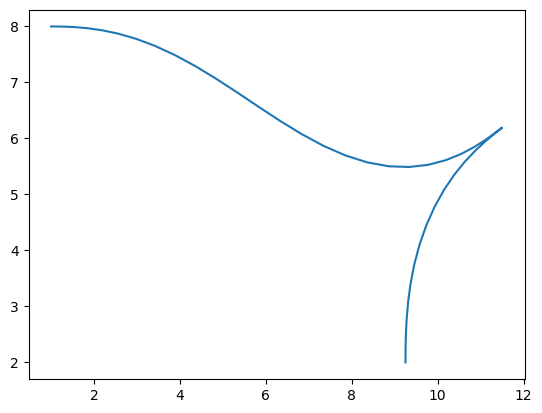

In [7]:
import matplotlib.pyplot as plt

plt.plot(xks[:, 0], xks[:, 1])
plt.show()